<a href="https://colab.research.google.com/github/sureshkumar2704/Medicinal-Plant-Classification/blob/main/Copy_of_notebooka53f6e0be4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [3]:
# Input paths (Kaggle-specific)
leaf_path = Path(r"S:\archive\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset")
plant_path = Path(r"S:\archive\Indian Medicinal Leaves Image Datasets\Medicinal plant dataset")



In [4]:

# Output folders
base_dir = Path("/kaggle/working/combined_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"






In [5]:
for d in [train_dir, val_dir]:
    d.mkdir(parents=True, exist_ok=True)



In [6]:
def prepare_dataset(source_dir, label_prefix):
    classes = sorted([cls for cls in os.listdir(source_dir) if os.path.isdir(source_dir / cls)])
    for cls in tqdm(classes, desc=f"Processing {label_prefix}"):
        img_dir = source_dir / cls
        images = list(img_dir.glob("*.*"))
        label = f"{label_prefix}_{cls}"

        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for subset, imgs in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
            cls_dir = subset / label
            cls_dir.mkdir(parents=True, exist_ok=True)
            for img in imgs:
                shutil.copy(img, cls_dir / img.name)


In [7]:
# Combine both datasets
prepare_dataset(leaf_path, "leaf")
prepare_dataset(plant_path, "plant")


Processing plant: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]


In [8]:
# Parameters
img_size = (224, 224)
batch_size = 32



In [9]:
# Data generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)



In [10]:
train_data = train_gen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = val_gen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)



Found 8947 images belonging to 120 classes.
Found 1921 images belonging to 120 classes.
Found 1977 images belonging to 120 classes.


In [11]:
# VGG16 Transfer Learning
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False



In [12]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)



In [13]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [14]:
# Train
history = model.fit(train_data, validation_data=val_data, epochs=10)



c:\Users\sundara pandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 946s 3s/step - accuracy: 0.0476 - loss: 4.6047 - val_accuracy: 0.2894 - val_loss: 3.6682
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.2175 - loss: 3.5648 - val_accuracy: 0.4498 - val_loss: 2.8781
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 993s 4s/step - accuracy: 0.3543 - loss: 2.8671 - val_accuracy: 0.5320 - val_loss: 2.4303
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.4540 - loss: 2.3731 - val_accuracy: 0.6351 - val_loss: 2.0191
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 4197s 5s/step - accuracy: 0.5319 - loss: 2.0084 - val_accuracy: 0.6575 - val_loss: 1.7606
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step - accuracy: 0.5967 - loss: 1.7317 - val_accuracy: 0.7043 - val_loss: 1.5712
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - accuracy: 0.6666 - loss: 1.4716 - val_accuracy: 0.7408 - val_loss: 1.4180
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 931s 3s/step - accuracy: 0.7001 - loss: 1.3162 - val_acc

In [23]:
# Save
model.save("/kaggle/working/medicinal_model.keras")


In [19]:
# Evaluate on test set
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2f}")



62/62 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.7366 - loss: 1.2524
Test Accuracy: 0.80


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


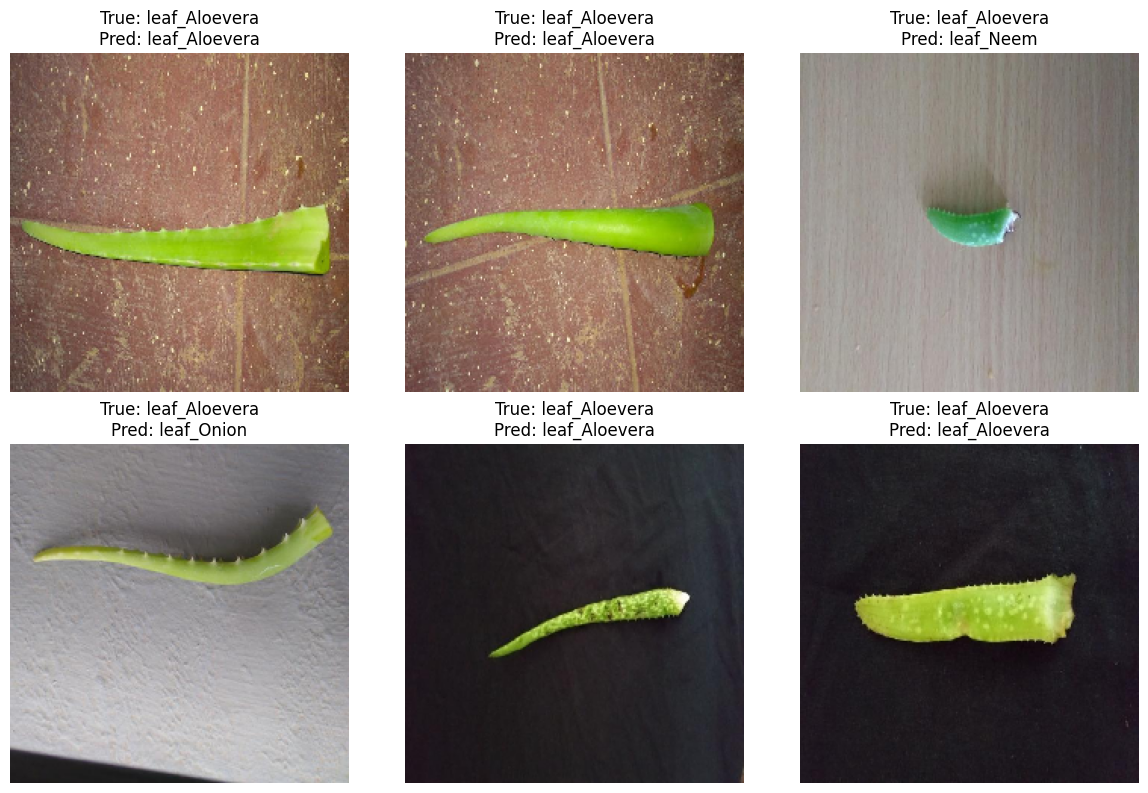

In [17]:
# View some predictions
import matplotlib.pyplot as plt

x_test, y_test = next(test_data)
predictions = model.predict(x_test)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
class_labels = list(test_data.class_indices.keys())

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
